In [1]:
import os
import tensorflow as tf

from TCC.model_util import ImgTester, model_path
from TCC.model_util import Saver
from TCC.model_util import load_all_imgs
from TCC.models.unet_v2 import unet_v2_get_model

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [3]:
image_size = (128,128)
epochs = 30
batch_size= 8
validation_split= 0.2
f = [64, 128]
threshold = 0.5
metric_name = "mean_iou_threshold"
metric = tf.keras.metrics.MeanIoU(num_classes=2)
def mean_iou_threshold(y_true, y_pred):
    y_pred = y_pred.numpy()
    y_pred[y_pred > threshold]= 1
    y_pred[y_pred <= threshold] = 0
    metric.reset_states()
    metric.update_state(y_true, y_pred)
    return metric.result().numpy()

os.chdir("../..")
base_output_path = '../imagens_cra/result/v2/unet_interna_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation_interna/cra"

print("base_output_path:", base_output_path)
try:
    os.mkdir(base_output_path)
except OSError as error:
    pass


base_output_path: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)


In [4]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)
validImgs = load_all_imgs(y_dir,image_size, 0)


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation_interna/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [5]:
img_to_test = int(len(trainImgs) * 0.8)
x_train = trainImgs[0:img_to_test]
y_train = validImgs[0:img_to_test]
x_val = trainImgs[img_to_test:]
y_val = validImgs[img_to_test:]
validation_data = (x_val, y_val)
print("ImgToTest:",img_to_test)
print("Validation_data_size:", len(validation_data[0]))

ImgToTest: 527
Validation_data_size: 132


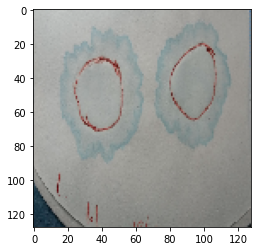

In [6]:
import matplotlib.pyplot as plt
plt.imshow(trainImgs[0])

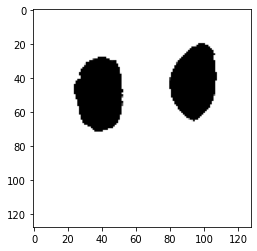

In [7]:
plt.imshow(validImgs[0], cmap=plt.cm.binary)

In [8]:
model =  unet_v2_get_model(image_size, 1, 'sigmoid', filters=f)
model.compile(run_eagerly=True,optimizer="adam", loss="binary_crossentropy", metrics=mean_iou_threshold)
model.summary()

down_sampling_filters: [64, 128]
up_sampling_filters: [128, 64, 32]
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
__________________________

In [9]:
callbacks = tf.keras.callbacks.ModelCheckpoint(
    model_path(base_output_path),
    verbose=0,
    save_best_only=True,
)
history = model.fit(
    x_train, y_train,
    epochs=epochs,  batch_size=batch_size, callbacks=callbacks,
    validation_data=validation_data,
)

Epoch 1/30
66/66 [==============================] - 9s 99ms/step - loss: 0.5972 - mean_iou_threshold: 0.6318 - val_loss: 1.9992 - val_mean_iou_threshold: 0.4356

saved to: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)\acc_por_epocas


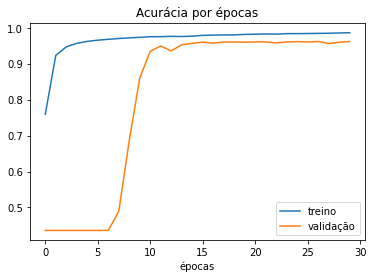

In [10]:
internal_saver = Saver(model, history, base_output_path)
internal_saver.save_metrics(metric_name)

saved to: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)\loss_por_epocas


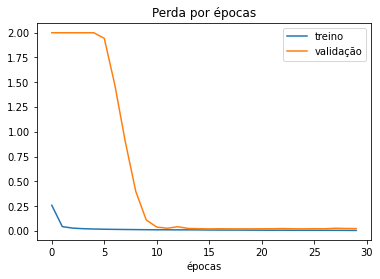

In [11]:
internal_saver.save_loss()

In [12]:
internal_saver.save_history()

saved to: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)\history.json
saved to: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)\history.csv


found 659 img to test

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Write metrics to: ../imagens_cra/result/v2/unet_interna_epoch_30_size_(128, 128)\metrics.csv


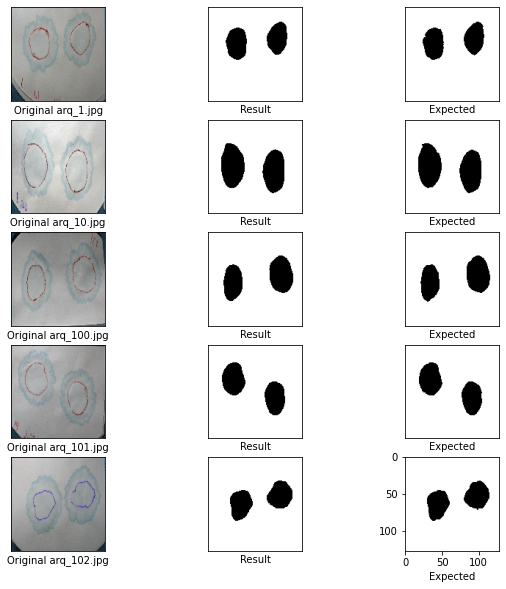

In [13]:
imgTester_metrics = [metric]
imgTester = ImgTester(base_output_path, x_dir, y_dir, image_size)
dependencies = {
    metric_name: mean_iou_threshold,
}
imgTester.test(-1, 5, imgTester_metrics, threshold, dependencies)